In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import minmax_scale,StandardScaler
from tqdm import tqdm_notebook

In [ ]:
# os.chdir(r"/raid6/roozbeh/traffic_cam_data/")

In [2]:
os.chdir(r"C:\Users\Roozbeh\Vehicular Data\London")

In [3]:
df = pd.read_csv('AA_LONDON_DATA_VER3_DATA_TABLE.csv')

In [4]:
camdf = pd.read_csv('AA_LONDON_CAMERA_DATA_TABLE.csv')

In [5]:
os.chdir(r"./spatio_temporal_London/")

In [6]:
df[:2]

,S_NO,CAMERA_NAME,DOWNLOAD_DATE,IMG_NAME,DENSITY_VALUE,DL_TIMESTAMP_LOCAL,COMMENTS,CAMERA_ID,DL_TIMESTAMP_CITY,SELECT_FLAG,RED,GREEN,BLUE
0,896208,549744,22-NOV-10,1290433594,16109.680,22-NOV-10 02.46.34.000000000 PM,NaN,182,22-NOV-10 01.46.34.000000000 PM,1,63621.507812,65366.414062,64108.488281
1,896209,549744,22-NOV-10,1290434044,11318.897,22-NOV-10 02.54.04.000000000 PM,NaN,182,22-NOV-10 01.54.04.000000000 PM,1,64379.992188,66520.500000,65209.515625


In [7]:
camdf[:2]

,CAMERA_ID,CAMERA_NAME,CAMERA_DESC,EASTING,NORTHING,GEO_LAT,GEO_LON,CONGESTION_ZONE
0,105,546600,A4 Cromwell Road by Earls Court Road,525351.39,178843.06,51.494572,-0.195707,0
1,106,546610,A4 Great West Road By Macbeth Street,522781.00,178369.00,51.490875,-0.232884,0


In [8]:
mergedf = df.merge(camdf,left_on="CAMERA_ID",right_on="CAMERA_ID")

tdf = mergedf[["CAMERA_ID","GEO_LON","GEO_LAT","DL_TIMESTAMP_CITY","DENSITY_VALUE"]].copy()

tdf['TIMESTAMP']  = pd.to_datetime(tdf['DL_TIMESTAMP_CITY'],format="%d-%b-%y %I.%M.%S.000000000 %p")

try:
    tdf.drop("DL_TIMESTAMP_CITY",axis=1,inplace=True)
except:
    print("column doesn't exist")

In [9]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04


In [10]:
tdf["TIME_EPOCH"] = (tdf.TIMESTAMP.astype(np.int64) // 10**9)

In [11]:
tdf["TIME_EPOCH"] -= tdf.TIME_EPOCH.min()

In [12]:
tdf.TIMESTAMP.describe()

count                  896246
unique                 401908
top       2010-10-24 10:17:03
freq                      163
first     2010-10-11 09:55:01
last      2010-11-22 18:59:42
Name: TIMESTAMP, dtype: object

In [13]:
tdf["TIME_BUCKET"] = tdf.TIME_EPOCH//600

In [14]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP,TIME_EPOCH,TIME_BUCKET
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34,3642693,6071
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04,3643143,6071


In [15]:
yscaler = StandardScaler()

In [16]:
yscaler.fit(tdf["DENSITY_VALUE"].values.reshape((-1,1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
tdf.loc[:,"SCALED_DENSITY_VALUE"] = yscaler.transform(tdf["DENSITY_VALUE"].values.reshape((-1,1)))

In [18]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP,TIME_EPOCH,TIME_BUCKET,SCALED_DENSITY_VALUE
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34,3642693,6071,-0.459432
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04,3643143,6071,-0.906670


In [19]:
Xfeatures = ["GEO_LON","GEO_LAT"]
Tfeature = "TIME_EPOCH"
target = "SCALED_DENSITY_VALUE"

In [20]:
from pandas.plotting import autocorrelation_plot

In [21]:
tdf_10min = tdf.groupby(["CAMERA_ID",pd.Grouper(key="TIMESTAMP",freq='10min')]).mean()

In [22]:
tdf_1min = tdf.groupby(["CAMERA_ID",pd.Grouper(key="TIMESTAMP",freq='1min')]).mean()

In [23]:
tdf_30min = tdf.groupby(["CAMERA_ID",pd.Grouper(key="TIMESTAMP",freq='30min')]).mean()

In [24]:
tdf_1h = tdf.groupby(["CAMERA_ID",pd.Grouper(key="TIMESTAMP",freq='1H')]).mean()

In [25]:
tdf_10min.TIME_EPOCH = tdf_10min.TIME_EPOCH.astype(np.int64)
tdf_10min.TIME_BUCKET = tdf_10min.TIME_BUCKET.astype(np.int64)

In [26]:
tdf_1min.TIME_EPOCH = tdf_1min.TIME_EPOCH.astype(np.int64)
tdf_1min.TIME_BUCKET = tdf_1min.TIME_BUCKET.astype(np.int64)

In [27]:
tdf_30min.TIME_EPOCH = tdf_30min.TIME_EPOCH.astype(np.int64)
tdf_30min.TIME_BUCKET = tdf_30min.TIME_BUCKET.astype(np.int64)

In [28]:
tdf_1h.TIME_EPOCH = tdf_1h.TIME_EPOCH.astype(np.int64)
tdf_1h.TIME_BUCKET = tdf_1h.TIME_BUCKET.astype(np.int64)

In [29]:
tdf_10min[:5]

GEO_LON    GEO_LAT  DENSITY_VALUE  TIME_EPOCH  \
CAMERA_ID TIMESTAMP                                                             
1         2010-10-11 09:50:00 -0.218065  51.481782     51667.9180          90   
          2010-10-11 10:00:00 -0.218065  51.481782     39100.7650         720   
          2010-10-11 10:10:00 -0.218065  51.481782     45671.0210        1440   
          2010-10-11 10:20:00 -0.218065  51.481782     45811.2860        1710   
          2010-10-11 10:30:00 -0.218065  51.481782     49308.1445        2340   

                               TIME_BUCKET  SCALED_DENSITY_VALUE  
CAMERA_ID TIMESTAMP                                               
1         2010-10-11 09:50:00            0              2.860066  
          2010-10-11 10:00:00            1              1.686874  
          2010-10-11 10:10:00            2              2.300232  
          2010-10-11 10:20:00            2              2.313327  
          2010-10-11 10:30:00            3              2.639772

In [30]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
def objfunc(order, exog, endog):
    try:
        fit = ARIMA(endog, order, exog).fit()
        return fit.aic
    except Exception as e:
#         print("EXCEPTION: ",e)
        return 1e8

from scipy.optimize import brute
grid = (slice(3, 8, 1), slice(0, 1, 1), slice(3, 8, 1))

In [32]:
import warnings; warnings.simplefilter('ignore')

In [33]:
from sklearn.model_selection import TimeSeriesSplit

In [34]:
tsv = TimeSeriesSplit(n_splits=4)

In [35]:
hyper_param_per_camera = {}
rmses_per_camera = {}

In [35]:
import pickle

In [37]:
with open("models_params.pickle",'rb') as f:
    models_params= pickle.load(f)

In [38]:
models_params

{1: {0: {'callback': None,
   'disp': 0,
   'maxiter': 50,
   'method': None,
   'order': (1, 1, 1),
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': (1, 0, 1, 24),
   'solver': 'lbfgs',
   'start_params': None,
   'suppress_warnings': False,
   'transparams': True,
   'trend': 'c'},
  1: {'callback': None,
   'disp': 0,
   'maxiter': 50,
   'method': None,
   'order': (2, 0, 0),
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': (1, 0, 0, 24),
   'solver': 'lbfgs',
   'start_params': None,
   'suppress_warnings': False,
   'transparams': True,
   'trend': 'c'},
  2: {'callback': None,
   'disp': 0,
   'maxiter': 50,
   'method': None,
   'order': (2, 0, 0),
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': (1, 0, 0, 24),
   'solver': 'lbfgs',
   'start_params': None,
   'suppress_warnings': False,
   'transparams': True,
   'trend': 'c'},
  3: {'callback': N

In [39]:
from pmdarima.arima import auto_arima
import pmdarima as pmd

In [37]:
rmse_per_cam_per_halfhour_df = pd.DataFrame(columns=["camera_id","rmse_f1","rmse_f2","rmse_f3","rmse_f4"])

In [62]:
def plot_predictions(data, cam_id_to_vis, models_params):
    group = data.groupby("CAMERA_ID").get_group(cam_id_to_vis)

    group = group.reset_index(level=0)
    ts = group.SCALED_DENSITY_VALUE

    for i,(train_index, test_index) in enumerate(tsv.split(ts)):
        model = pmd.ARIMA(order=models_params[cam_id_to_vis][i]["order"],
                          seasonal_order=models_params[cam_id_to_vis][i]["seasonal_order"])
        model.fit(ts[train_index])
        fc = model.predict(len(test_index))
        plt.plot(ts[test_index].values)
        plt.plot(fc)
        plt.show()

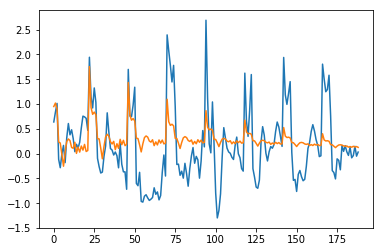

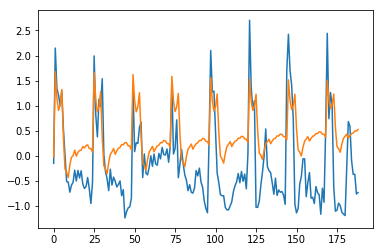

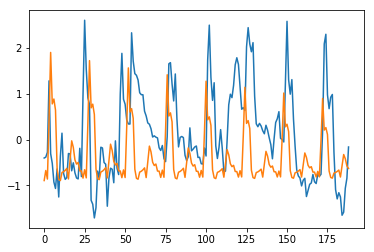

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


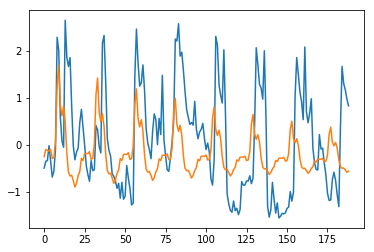

In [63]:
plot_predictions(tdf_30min,2,models_params)

In [88]:
arima_rmses = pd.read_csv("rmse_per_cam_per_0.5hour_df.csv")

In [89]:
lstm_incomplete_rmses = pd.read_csv("lstm_rmse_scaled_per_cam_per_halfhour_df.csv")

In [90]:
both = lstm_incomplete_rmses.merge(arima_rmses,on="camera_id")

In [101]:
both

,camera_id,rmse_f1_x,rmse_f2_x,rmse_f3_x,rmse_f4_x,rmse_f1_y,rmse_f2_y,rmse_f3_y,rmse_f4_y
0,62.0,0.764521,0.833765,0.971358,0.851654,1.151174,1.075789,1.308830,1.212258
1,45.0,0.851817,1.010067,1.231785,0.943963,0.946608,0.856395,1.020714,0.893941
2,3.0,0.834153,0.909886,0.895341,0.897173,5.073446,0.965734,1.472083,1.129966
3,49.0,0.849326,0.665152,0.830798,0.797500,1.390124,0.663713,0.937202,0.767860
4,42.0,0.959265,0.834589,0.461463,0.720648,0.886115,1.038098,0.926683,1.231513
5,44.0,0.625839,0.698682,0.657367,0.758903,2.713107,1.282851,1.139351,0.964130
6,9.0,0.623049,0.925500,0.944453,0.902717,0.501829,0.845964,1.022375,1.053157
7,10.0,0.770236,1.045587,0.830947,1.007423,1.428021,1.161817,0.869813,0.880010
8,36.0,1.056644,1.004866,1.033273,0.830044,0.944789,1.157281,1.213366,1.189234
9,31.0,2.332583,1.208775,1.369909,1.001431,0.787826,1.155080,1.063040,0.888770


In [91]:
lstm_mean = both.apply(lambda x : np.mean(x[1:5]),axis=1)
lstm_min = both.apply(lambda x : np.min(x[1:5]),axis=1)
arima_mean = both.apply(lambda x : np.mean(x[5:]),axis=1)
arima_min = both.apply(lambda x : np.min(x[5:]),axis=1)

In [92]:
lstm_arima_means = pd.DataFrame(data= {'lstm':lstm_mean,'arima' : arima_mean})
lstm_arima_mins = pd.DataFrame(data= {'lstm':lstm_min,'arima' : arima_min})

In [93]:
lstm_arima_mins[:5]

,arima,lstm
0,1.075789,0.764521
1,0.856395,0.851817
2,0.965734,0.834153
3,0.663713,0.665152
4,0.886115,0.461463


In [86]:
lstm_arima_mins[:5]

,arima,lstm
0,0.577893,0.850201
1,0.585165,0.548755
2,0.965734,0.695104
3,0.989322,0.698567
4,0.484077,0.601643


In [94]:
lstm_arima_mins.describe()

,arima,lstm
count,33.000000,33.000000
mean,0.801999,0.741429
std,0.201090,0.153633
min,0.465665,0.461463
25%,0.663713,0.625832
50%,0.825138,0.726971
75%,0.944789,0.810281
max,1.202742,1.228847


In [107]:
lstm_arima_means[lstm_arima_means.lstm < 0.8]

,arima,lstm
3,0.939725,0.785694
4,1.020602,0.743991
5,1.524860,0.685198
11,1.433330,0.730841
22,1.518064,0.694056
23,0.834388,0.714106
25,1.041677,0.770659
26,1.593103,0.790660
31,0.828123,0.734094
32,1.147756,0.672562


In [95]:
lstm_arima_means[:5]

,arima,lstm
0,1.187013,0.855324
1,0.929415,1.009408
2,2.160307,0.884138
3,0.939725,0.785694
4,1.020602,0.743991


In [96]:
lstm_arima_means.describe()

,arima,lstm
count,33.000000,33.000000
mean,1.120638,0.893003
std,0.382508,0.204621
min,0.729844,0.672562
25%,0.863696,0.785694
50%,1.010436,0.838100
75%,1.187013,0.913548
max,2.239342,1.612586


In [97]:
lstm_arima_means[lstm_arima_means.arima < lstm_arima_means.lstm]

,arima,lstm
1,0.929415,1.009408
9,0.973679,1.478174
18,0.863696,1.022364
21,0.759005,1.098950
27,0.738110,1.125161
28,0.729844,1.043106
29,0.748901,0.825154


In [98]:
lstm_incomplete_rmses.apply(lambda x : np.mean(x[1:]),axis=1).mean()

0.8930033403525203

In [99]:
both[:2]

,camera_id,rmse_f1_x,rmse_f2_x,rmse_f3_x,rmse_f4_x,rmse_f1_y,rmse_f2_y,rmse_f3_y,rmse_f4_y
0,62.0,0.764521,0.833765,0.971358,0.851654,1.151174,1.075789,1.308830,1.212258
1,45.0,0.851817,1.010067,1.231785,0.943963,0.946608,0.856395,1.020714,0.893941


In [100]:
both[both["rmse_f4_x"] >= both["rmse_f4_y"]]

,camera_id,rmse_f1_x,rmse_f2_x,rmse_f3_x,rmse_f4_x,rmse_f1_y,rmse_f2_y,rmse_f3_y,rmse_f4_y
1,45.0,0.851817,1.010067,1.231785,0.943963,0.946608,0.856395,1.020714,0.893941
3,49.0,0.849326,0.665152,0.830798,0.797500,1.390124,0.663713,0.937202,0.767860
7,10.0,0.770236,1.045587,0.830947,1.007423,1.428021,1.161817,0.869813,0.880010
9,31.0,2.332583,1.208775,1.369909,1.001431,0.787826,1.155080,1.063040,0.888770
18,23.0,0.941304,0.982079,1.110962,1.055112,0.882879,0.739327,0.879388,0.953191
24,58.0,0.867844,0.730529,0.883715,0.725825,1.629654,0.490899,0.505712,0.624430
27,50.0,0.967079,1.365316,1.156708,1.011539,0.512030,0.615435,1.033230,0.791747
28,51.0,0.974368,0.938184,1.359189,0.900684,1.301201,0.673834,0.478676,0.465665
29,52.0,0.858749,0.803694,0.913616,0.724555,1.304347,0.502890,0.637425,0.550941


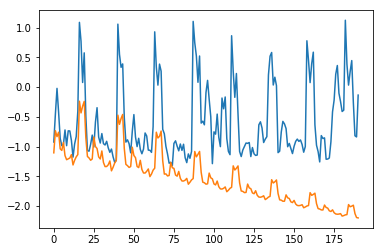

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


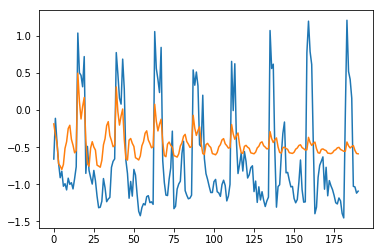

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


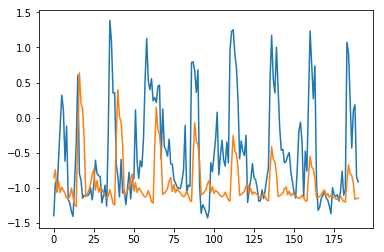

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


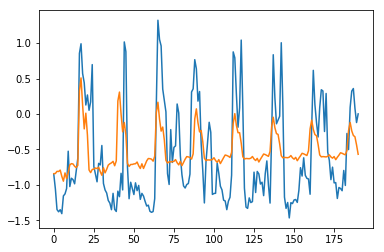

In [66]:
plot_predictions(tdf_30min,97,models_params)